In [1]:
import os
import json
from tqdm import tqdm

import pandas as pd
import numpy as np

import torch

import matplotlib.pyplot as plt
import seaborn as sns

from config.config_types import AppConfig
from utils.paths import VOL_EXPERIMENTS_DIR
from utils.inference_utils import format_legend_name

In [2]:
def load_cfg(name, trial, fold_num=0):
    # -------- load config --------
    base = f"{VOL_EXPERIMENTS_DIR}/{name}/{trial}/"
    conifg_path = f"{base}config_snapshot.json"

    with open(conifg_path, 'r') as f:
        cfg = json.load(f)

    cfg = cfg["cfg"]

    cfg = AppConfig.from_dict(cfg)

    return cfg

def load_ckpt(name, trial, fold_num=0):
    base = f"{VOL_EXPERIMENTS_DIR}/{name}/{trial}/"
    ckpt_path = f"{base}fold_{fold_num:03d}/model_best.pt"
    checkpoint = torch.load(ckpt_path, map_location="cuda")

    return checkpoint

def get_losses(ckpt):
    
    history = ckpt.get("history", None)
    if not history:
        print("No training history found in checkpoint.")
        return None
    
    epochs = np.arange(1, len(tr_losses) + 1)

    tr_losses = np.array([h["tr_loss"] for h in history])

    val_losses = np.array([h["val_loss"] for h in history]) 

    test_losses = np.array([h["test_loss"] for h in history]) 

    return [tr_losses, val_losses, test_losses]

def load_performance(name, trial, fold_num=0):
    base = f"{VOL_EXPERIMENTS_DIR}/{name}/{trial}/analysis/fold_avg_metrics.csv"
    df = pd.read_csv(base)
    df = df.set_index('Model')

    tr_mse = df.loc["NN", 'Train MSE']
    test_mse = df.loc["NN", 'Test MSE']

    ols_tr_mse = df.loc["OLS", 'Train MSE']
    ols_test_mse = df.loc["OLS", 'Test MSE']

    return float(tr_mse), float(test_mse), float(ols_tr_mse), float(ols_test_mse)

In [50]:
pippo = (1, 2, 3, 4)
pippo[:2]

(1, 2)

In [4]:
dirs = [d for d in os.listdir(VOL_EXPERIMENTS_DIR) if 'snr' in d]

results = {}

for i, dir in tqdm(enumerate(dirs)):
    dir_results = {}
    ols_results = {}
    trials = os.listdir(f'{VOL_EXPERIMENTS_DIR}/{dir}')
    
    for t in trials:
        cfg = load_cfg(dir, t)
        noise = cfg.walkforward.noise

        all_mses = load_performance(dir, t)
        mses = all_mses[:2]
        ols_mses = all_mses[2:]


        dir_results[noise] = {
            "model": mses,
            "ols": ols_mses
        }

    results[dir] = dir_results





12it [00:00, 13.81it/s]


In [45]:
# ---- reshape into tidy dataframe ----
rows = []
for d, noise_dict in results.items():
    for noise, pack in noise_dict.items():
        rows.append({"dir": d, "noise": noise, "method": "Model", "mse_idx": 0, "mse": pack["model"][0]})
        rows.append({"dir": d, "noise": noise, "method": "Model", "mse_idx": 1, "mse": pack["model"][1]})
        #rows.append({"dir": d, "noise": noise, "method": "OLS",   "mse_idx": 0, "mse": pack["ols"][0]})
        #rows.append({"dir": d, "noise": noise, "method": "OLS",   "mse_idx": 1, "mse": pack["ols"][1]})

df_long = pd.DataFrame(rows).sort_values(["dir", "noise", "mse_idx", "method"])

# ensure proper ordering
df_long = df_long.sort_values(["dir", "noise"], ascending=[False, True])
df_long['dir'] = df_long['dir'].apply(lambda x: format_legend_name(x).replace(' SNR', '').replace(' 100', ''))
df_long['Architecture'] = df_long['dir'].apply(lambda x: x.split()[0])
df_long['Optimizer'] = df_long['dir'].apply(lambda x: x.split()[1])
df_long

,dir,noise,method,mse_idx,mse,Architecture,Optimizer
242,LSTM MUON,0.10,Model,0,0.101913,LSTM,MUON
243,LSTM MUON,0.10,Model,1,0.162890,LSTM,MUON
262,LSTM MUON,0.59,Model,0,0.169347,LSTM,MUON
263,LSTM MUON,0.59,Model,1,0.255398,LSTM,MUON
244,LSTM MUON,1.08,Model,0,0.204352,LSTM,MUON
...,...,...,...,...,...,...,...
17,MLP ADAM,4.02,Model,1,0.403419,MLP,ADAM
18,MLP ADAM,4.51,Model,0,0.322656,MLP,ADAM
19,MLP ADAM,4.51,Model,1,0.415794,MLP,ADAM
20,MLP ADAM,5.00,Model,0,0.334672,MLP,ADAM


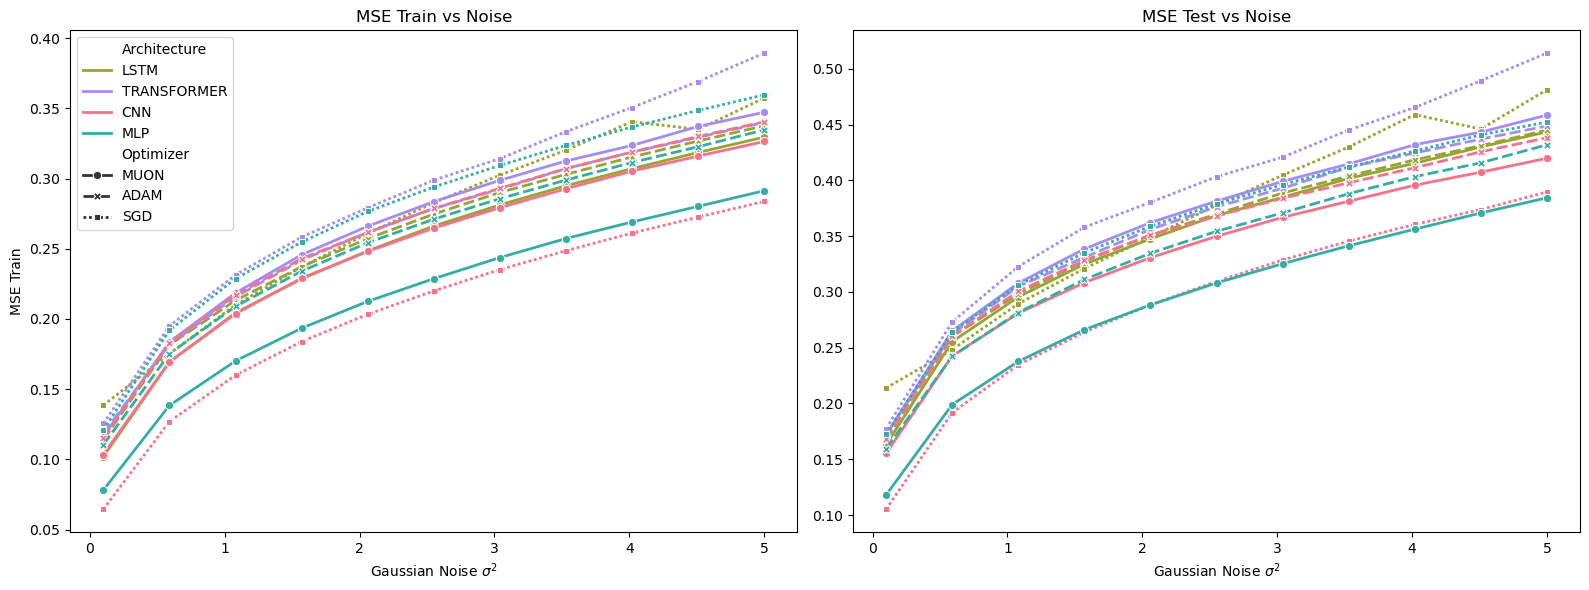

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context()

legends = ['MSE Train', 'MSE Test']

# Filter once
dfp = df_long.copy()

# Consistent colors across both plots
dirs_sorted = sorted(dfp["Architecture"].unique())
base = sns.color_palette("husl", n_colors=len(dirs_sorted))
palette = dict(zip(dirs_sorted, base))

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True, sharey=False)

for mse_idx in [0, 1]:
    ax = axes[mse_idx]
    
    df_sub = dfp[dfp["mse_idx"] == mse_idx]

    sns.lineplot(
        data=df_sub,
        x="noise",
        y="mse",
        hue="Architecture",
        style="Optimizer",
        linewidth=2,
        palette=palette,
        markers=True,
        ax=ax,
        legend=(mse_idx == 0)  # only show legend once
    )

    ax.set_title(f"{legends[mse_idx]} vs Noise")
    ax.set_xlabel(r"Gaussian Noise $\sigma^2$")
    if mse_idx == 0:
        ax.set_ylabel(legends[mse_idx])
    else:
        ax.set_ylabel("")

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df_long,
    x="noise",
    y="mse",
    hue="dir",
    marker="o",
    palette=palette,
    linewidth=1
)

plt.title("Train MSE vs Noise")
plt.xlabel(r"Gaussian Noise $\sigma$")
plt.ylabel("Train MSE")

plt.legend(title="Experiment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

ValueError: Could not interpret value `mse_0` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

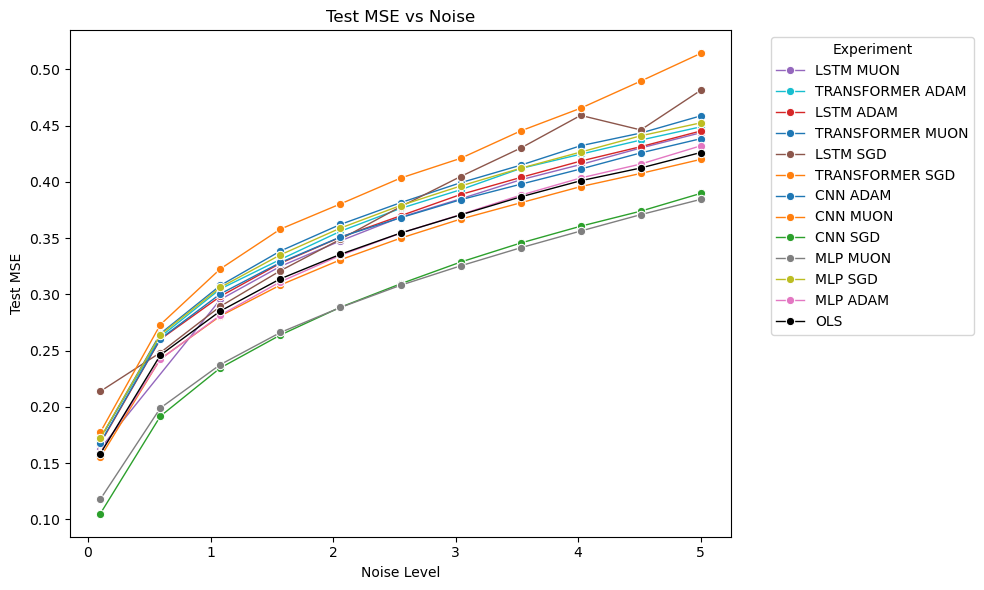

In [ ]:
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df_long,
    x="noise",
    y="mse_1",
    hue="dir",
    marker="o",
    palette=palette,
    linewidth=1
)

plt.title("Test MSE vs Noise")
plt.xlabel("Noise Level")
plt.ylabel("Test MSE")
plt.legend(title="Experiment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()